# Data Preparation for Language Modelling and Sentiment Analysis Classification

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import gzip
import re
import sklearn
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

from pathlib import Path
from sklearn.model_selection import train_test_split


##### Path to the folder containing the data

In [2]:
DATA_PATH = Path('../data/')

## Data import scripts

### Scraped Datasets

In [3]:
def inspect_df(df):
    print('First 5 reviews')
    print(df.head())
    print('Number of reviews per rating')
    print(df.groupby('label').count())
    
    df.plot.hist(bins=5)
    
    
def load_and_clean(file_path, rating_column_name, text_column_name):
    df = pd.read_csv(DATA_PATH/file_path)
    df = df[[rating_column_name, text_column_name]]
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    df.rename(columns = {rating_column_name : 'label', text_column_name : 'text'}, inplace=True)
    df = df[df['label'].str.contains(r'\d') == True]
    df = df[df['text'].str.contains(r'\w+') == True]
    df['label'] = pd.to_numeric(df['label'].apply(lambda x: re.findall('\d', x)[0]))
    df.loc[(df.label==0), 'label'] = 1 #Converts 0.5 to 1
  
#     print(inspect_df(df))
    return df

### Existing Datasets (Amazon)

##### Data import script adapted from McAuley. [Link](http://jmcauley.ucsd.edu/data/amazon/)

In [4]:
# import pandas as pd
# import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

def clean_data(df, review_text='reviewText', review_score='overall'):
    df = df[[review_score, review_text]]
    df = df.rename(columns= {review_score : 'label', review_text : 'text'})
    df['label'] = pd.to_numeric(df['label'], downcast='integer')
    return df


## Language identifier functions

In [5]:
def try_detect(x):
    try:
        y = detect(x)
    except LangDetectException:
        y = 'No lang'
    return y

def keep_lang(df, lang='en'):
    """Returns two dataframes, one containing only reviews of the specified language,
    and the other containing all the reviews that were removed."""
    if lang == 'en':
        lang_long = 'english'
    elif lang == 'fr':
        lang_long = 'french'
    elif lang_long == 'es':
        lang_long = 'spanish'
    else:
        lang_long = lang
    ask = input('It make take a while, are you sure? (y/n)')
    if (ask == 'y') | (ask == 'yes'):
        print('finding non {0} reviews...'.format(lang_long))
        df1 = df.copy()
        df1['lang'] = df1['text'].apply(lambda x: try_detect(x))
        print('removing non english reviews')
        non_en = str(len(df1[df1['lang'] != lang]))
        df2 = df1[df1['lang'] != lang]
        df1 = df1[df1['lang'] == lang]
        df1.drop(columns='lang', inplace=True)
        print('{0} non {1} reviews were found and deleted'.format(non_en, lang_long))
        return df1, df2
    else:
        print('You may try again at a later time.')


## Sampling scripts

In [45]:
def clas_trans_bin(df):
    cdf = df.copy()
    cdf.loc[(cdf.label==0) | (cdf.label==1) | (cdf.label==2), 'label'] = 0 #Negative reviews (0.5 to 2 out of 5)
    cdf.loc[(cdf.label==4) | (cdf.label==5), 'label'] = 1 #Positive reviews (4 and 5 out of 5)
    cdf.loc[(cdf.label==3), 'label'] = 2 #Neutral review (Can't be used for binary classification task)
    cdf = cdf[cdf['label'] != 2]
#     print(inspect_df(cdf))
    
    return cdf

def lm_trans(df):
    ldf=df.copy()
    ldf.loc[(ldf.label<10), 'label'] = 0
#     print(inspect_df(ldf))
    
    return ldf



### This is to export the training, testing, and validation datasets to csv for modeling. 
def data_to_csv(data, max_pos=30000, max_neg=30000, test_size=0.1):
    clas_data=clas_trans_bin(data)
    len_neg = len(clas_data[clas_data['label']==0])
    print(len_neg)
    len_pos = len(clas_data[clas_data['label']==1])
    print(len_pos)
    if (len_neg < max_neg) | (len_pos < max_pos):
        raise ValueError('Number of positive ({}) or negative ({}) reviews is less than passed in the argument.'.format(len_pos, len_neg))
    else:
        #Classifier model data for import
        neg_data = clas_data[clas_data['label']==0].sample(n=max_neg, random_state=10)
        pos_data = clas_data[clas_data['label']==1].sample(n=max_pos, random_state=10)
        clas_data = pd.concat([neg_data, pos_data], ignore_index=True)
        trn_df, valtest_df = train_test_split(clas_data, test_size=0.2)
        val_df, test_df = train_test_split(valtest_df, test_size=0.5)
        trn_df.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
        val_df.to_csv(CLAS_PATH/'val.csv', header=False, index=False)
        test_df.to_csv(CLAS_PATH/'test.csv', header=False, index=False)
        print('classifier model datasets')
        print('training set : {0} reviews exported'.format(len(trn_df)))
        print('validation set : {0} reviews exported'.format(len(val_df)))
        print('testing set : {0}'.format(len(test_df)))
        
        #Language model data for import
        lm_data = lm_trans(data)
        lm_data = sklearn.utils.shuffle(lm_data, random_state=10)
        lm_data = lm_data.sample(min(len(lm_data), 100000))
        trn_df, val_df = train_test_split(lm_data, test_size=0.1)
        trn_df.to_csv(LM_PATH/'train.csv', header=False, index=False)
        val_df.to_csv(LM_PATH/'test.csv', header=False, index=False)

        print('')
        print('language model datasets')
        print('training set : {0} reviews exported'.format(len(trn_df)))
        print('validation set : {0} reviews exported'.format(len(val_df)))


## Amazon Cell Phones and Accessories

In [18]:
LM_PATH = Path('../data/cellphones_lm/')
LM_PATH.mkdir(exist_ok=True)

CLAS_PATH = Path('../data/cellphones_clas')
CLAS_PATH.mkdir(exist_ok=True)

In [19]:
cell_phones = clean_data(getDF('../data/reviews_Cell_Phones_and_Accessories_5.json.gz'))

In [22]:
lm_data = lm_trans(cell_phones)

First 5 reviews
   label                                               text
0      1  They look good and stick good! I just don't li...
1      1  These stickers work like the review says they ...
2      1  These are awesome and make my phone look so st...
3      1  Item arrived in great time and was in perfect ...
4      1  awesome! stays on, and looks great. can be use...
Number of reviews per rating
         text
label        
0       24343
1      148657


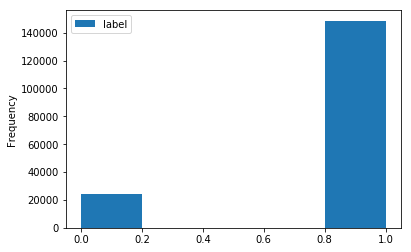

In [43]:
clas_data = clas_trans_bin(cell_phones)
inspect_df(clas_data)

In [44]:
len(clas_data[clas_data['label']==0])

24343

In [53]:
data_to_csv(cell_phones, max_pos=30000, max_neg=20000)

24343
148657
classifier model datasets
training set : 40000 reviews exported
validation set : 5000 reviews exported
testing set : 5000

language model datasets
training set : 174995 reviews exported
validation set : 19444 reviews exported


## TripAdvisor Restaurant Reviews

In [8]:
LM_PATH = Path('../data/restaurants_lm/')
LM_PATH.mkdir(exist_ok=True)

CLAS_PATH = Path('../data/restaurants_clas')
CLAS_PATH.mkdir(exist_ok=True)

In [13]:
# r1 = load_and_clean('ottawa_restaurants.csv', 'global_rating', 'review_text')
# r2 = load_and_clean('restaurants_toronto.csv', 'global_rating', 'review_text')
# restaurants = pd.concat([r1, r2])

In [14]:
# restaurants_en, restaurants_other = keep_lang(restaurants)

It make take a while, are you sure? (y/n)y
finding non english reviews...
removing non english reviews
1485 non english reviews were found and deleted


In [16]:
# restaurants_en[0].to_csv(DATA_PATH/'restaurants_en.csv')

In [9]:
restaurants = pd.read_csv(DATA_PATH/'restaurants_en.csv', index_col=0)

In [57]:
lm_data = lm_trans(restaurants)

First 5 reviews
   label                                               text
0      1  it is a nice place to buy italian food and to ...
1      1   Tried Pure a couple times while visiting Ottawa.
2      1  Had a great breakfast! very good service and v...
3      1  My first visit. This place is busy. Good idea ...
5      1  The food was really good and the service was a...
Number of reviews per rating
         text
label        
0       30566
1      199128


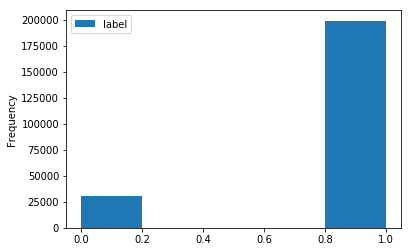

In [9]:
clas_data = clas_trans_bin(restaurants)
inspect_df(clas_data)

In [13]:
data_to_csv(restaurants, max_pos=20000, max_neg=20000)

30566
199128
classifier model datasets
training set : 32000 reviews exported
validation set : 4000 reviews exported
testing set : 4000

language model datasets
training set : 239176 reviews exported
validation set : 26576 reviews exported


## TripAdvisor Hotel Reviews

In [10]:
LM_PATH = Path('../data/hotels_lm/')
LM_PATH.mkdir(exist_ok=True)

CLAS_PATH = Path('../data/hotels_clas')
CLAS_PATH.mkdir(exist_ok=True)

In [18]:
hotels = load_and_clean('hotels_sandiego.csv', 'review_rating', 'review_text')

In [19]:
hotels_en, hotels_other = keep_lang(hotels, 'en')

It make take a while, are you sure? (y/n)y
finding non english reviews...
removing non english reviews
5299 non english reviews were found and deleted


In [21]:
hotels_en.to_csv(DATA_PATH/'hotels_en.csv')

In [11]:
hotels = pd.read_csv(DATA_PATH/'hotels_en.csv', index_col=0)

In [16]:
lm_data = lm_trans(hotels)

In [17]:
clas_data = clas_trans_bin(hotels)
# inspect_df(clas_data)

First 5 reviews
   label                                               text
1      1  This hotel was a great value for a city hotel ...
2      1  Urban Boutique has a great very helpful staff....
3      1  Rooms were so nice ! Very boutique-ish. Staff ...
4      1  Absolutely recommended this hotel to anyone. R...
5      1  We stayed here for my boyfriends birthday and ...
Number of reviews per rating
         text
label        
0       21276
1      165927


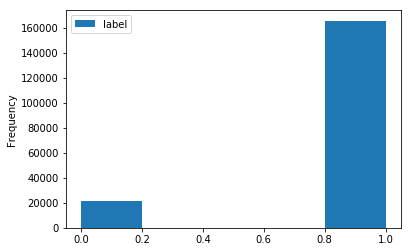

In [19]:
inspect_df(clas_data)

In [10]:
data_to_csv(hotels, max_pos=20000, max_neg=20000)

20541
162119
classifier model datasets
training set : 32000 reviews exported
validation set : 4000 reviews exported
testing set : 4000

language model datasets
training set : 186451 reviews exported
validation set : 20717 reviews exported


## TripAdvisor Things to Do Reviews

In [12]:
LM_PATH = Path('../data/activities_lm/')
LM_PATH.mkdir(exist_ok=True)

CLAS_PATH = Path('../data/activities_clas')
CLAS_PATH.mkdir(exist_ok=True)

In [58]:
a1 = load_and_clean('activities_toronto.csv', 'review_rating', 'review_text')

In [59]:
a2 = load_and_clean('activities_san_diego.csv', 'review_rating', 'review_text')

In [60]:
a3 = load_and_clean('activities_Alba_Dallas.csv', 'review_rating', 'review_text')

In [61]:
a4 = load_and_clean('activities_calgary.csv', 'review_rating', 'review_text')

In [62]:
activities = pd.concat([a1, a2, a3, a4])

In [63]:
print(activities.groupby('label').count())

         text
label        
1        5894
2        7495
3       26125
4       85146
5      187944


In [64]:
activities_en, activities_other = keep_lang(activities)

It make take a while, are you sure? (y/n)y
finding non english reviews...
removing non english reviews
583 non english reviews were found and deleted


In [65]:
activities_en.to_csv(DATA_PATH/'activities_en.csv')

In [13]:
activities = pd.read_csv(DATA_PATH/'activities_en.csv', index_col=0)

First 5 reviews
   label                                               text
0      1  a good rainy day activity. nice informative di...
1      0  I have been to many aquariums the world over, ...
2      1  If you haven’t gone yet, this is a place you m...
3      1  Great aquarium, my 18 year old insisted on a s...
4      1  We visited the aquarium as part of a combo tic...
Number of reviews per rating
         text
label        
0       13352
1      272599


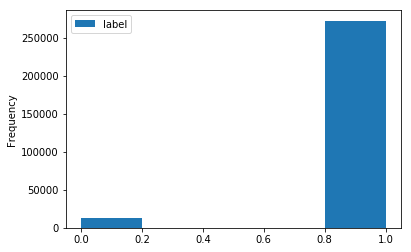

In [15]:
inspect_df(clas_trans_bin(activities))

In [ ]:
lm_data = lm_trans(activities)

In [ ]:
clas_data = clas_trans_bin(activities)

In [66]:
data_to_csv(activities, max_neg=13389, max_pos=15000)

13389
273090
classifier model datasets
training set : 22711 reviews exported
validation set : 2839 reviews exported
testing set : 2839

language model datasets
training set : 281343 reviews exported
validation set : 31261 reviews exported


## Rotten Tomatoes Consumer Movie Reviews

In [14]:
LM_PATH = Path('../data/movies_lm/')
LM_PATH.mkdir(exist_ok=True)

CLAS_PATH = Path('../data/movies_clas')
CLAS_PATH.mkdir(exist_ok=True)

In [2]:
movies_consumer = load_and_clean('rotten_reviews.csv', 'review_score', 'review_text')
movies_consumer['text'] = movies_consumer['text'].str[3:]
# # inspect_df(movies_consumer)

NameError: name 'load_and_clean' is not defined

In [47]:
movies_consumer.to_csv(DATA_PATH/'movies_clean.csv')

In [15]:
movies_consumer = pd.read_csv(DATA_PATH/'movies_clean.csv', index_col=0)

In [49]:
movies_consumer.count()

label    117687
text     117687
dtype: int64

First 5 reviews
    label                                               text
1       1  I really enjoyed this movie in class, great st...
2       0  ssssssssllllllllllooooooooooooowwwww. makes la...
5       0  I watched it for 5 minutes..... Felicity Kenda...
8       1  Historical accuracy and depth of story aside, ...
10      1                            A great family movie ??
Number of reviews per rating
        text
label       
0      36294
1      58354


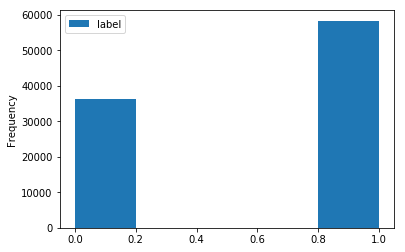

In [12]:
inspect_df(clas_trans_bin(movies_consumer))

In [53]:
movies_en, movies_other = keep_lang(movies_consumer)

It make take a while, are you sure? (y/n)y
finding non english reviews...
removing non english reviews
5207 non english reviews were found and deleted


In [54]:
movies_consumer.head()

,label,text
0,3,Particularly acute in catching the peculiar ma...
1,4,"I really enjoyed this movie in class, great st..."
2,2,ssssssssllllllllllooooooooooooowwwww. makes la...
4,3,An early Merchant/Ivory film featuring the rea...
5,2,I watched it for 5 minutes..... Felicity Kenda...


In [55]:
movies_en.to_csv(DATA_PATH/'movies_en.csv')

In [16]:
movies_consumer = pd.read_csv(DATA_PATH/'movies_en.csv', index_col=0)

In [56]:
data_to_csv(movies_consumer, max_pos=35000, max_neg=33000)

36294
58354
classifier model datasets
training set : 54400 reviews exported
validation set : 6800 reviews exported
testing set : 6800

language model datasets
training set : 105918 reviews exported
validation set : 11769 reviews exported


## General Language Model Dataset

In [25]:
LM_PATH = Path('../data/general_lm/')
LM_PATH.mkdir(exist_ok=True)

CLAS_PATH = Path('../data/general_clas')
CLAS_PATH.mkdir(exist_ok=True)

In [42]:
all_data = pd.concat([movies_consumer, activities, hotels, restaurants, cell_phones])
len(all_data)

1091860

In [39]:
general_lm_data = all_data.sample(n=100000, random_state=10)

First 5 reviews
        label                                               text
70797       3  Not bad but not great. Asked for extra everyth...
45655       4  Great event for an afternoon at the symphony w...
41557       2  My husband and I went to McEwan today. Disable...
124842      5  best suits movie of 2016, best love movie of 2...
121974      5  I have a lot of fun with these cases as I like...
Number of reviews per rating
        text
label       
1       5774
2       5507
3      11807
4      27315
5      49597


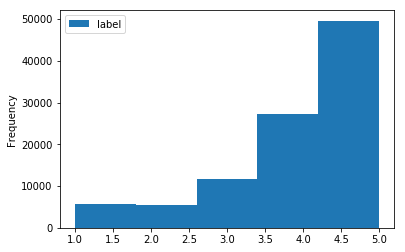

In [41]:
inspect_df(general_lm_data)

In [46]:
data_to_csv(all_data, max_pos=45000, max_neg=45000)

123637
838141
classifier model datasets
training set : 72000 reviews exported
validation set : 9000 reviews exported
testing set : 9000

language model datasets
training set : 90000 reviews exported
validation set : 10000 reviews exported
